# 🎯 Promotion Impact Model & Inventory Optimization

**Simple Model**: 
- Identify items with excess inventory (3x lead time)
- Identify items with low demand
- Predict promotion impact on demand
- Optimize inventory purchases for high service levels
- Forecast earnings from promotions


In [17]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score

# PuLP for Linear Programming
try:
    from pulp import *
    print("✅ PuLP imported successfully")
except ImportError:
    print("❌ PuLP not found. Installing...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "pulp"])
    from pulp import *
    print("✅ PuLP installed and imported")

import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")

print("🎯 Promotion Impact Model - Ready to Load Data")


✅ PuLP imported successfully
🎯 Promotion Impact Model - Ready to Load Data


In [18]:
# Load the clean dataset from our previous work
# For this demo, we'll create a simplified version

np.random.seed(42)

# Create 50 SKUs for simplicity
categories = ['Safety', 'Power Tools', 'Hand Tools', 'Electrical', 'Hardware']
n_skus = 50

data = []
for i in range(n_skus):
    sku_id = f"SKU{i+1:03d}"
    category = np.random.choice(categories)
    
    # Base metrics
    unit_cost = np.random.uniform(10, 100)
    selling_price = unit_cost * np.random.uniform(1.4, 2.0)  # 40-100% margin
    
    # Inventory metrics
    base_demand = np.random.uniform(5, 50)
    lead_time_days = np.random.uniform(3, 14)
    current_inventory = np.random.uniform(20, 200)
    
    # Calculate days of supply
    days_of_supply = (current_inventory / base_demand) * 7
    
    # Promotion eligibility (3x lead time OR low demand)
    excess_inventory = days_of_supply > (lead_time_days * 3)
    low_demand = base_demand < 15
    
    data.append({
        'sku_id': sku_id,
        'category': category,
        'unit_cost': round(unit_cost, 2),
        'selling_price': round(selling_price, 2),
        'base_demand': round(base_demand, 1),
        'lead_time_days': round(lead_time_days, 1),
        'current_inventory': round(current_inventory, 0),
        'days_of_supply': round(days_of_supply, 1),
        'excess_inventory': excess_inventory,
        'low_demand': low_demand,
        'promotion_candidate': excess_inventory or low_demand,
        'weight_lbs': round(np.random.uniform(0.5, 25), 1),
        'volume_cuft': round(np.random.uniform(0.01, 1.5), 3),
        'supplier_id': f"SUP{np.random.randint(1, 4):03d}"
    })

df = pd.DataFrame(data)

print(f"✅ Created Dataset: {len(df)} SKUs")
print(f"📊 Categories: {df['category'].nunique()}")
print(f"🎯 Promotion Candidates: {df['promotion_candidate'].sum()}")
print(f"📦 Excess Inventory: {df['excess_inventory'].sum()}")
print(f"📉 Low Demand: {df['low_demand'].sum()}")

display(df.head())


✅ Created Dataset: 50 SKUs
📊 Categories: 5
🎯 Promotion Candidates: 25
📦 Excess Inventory: 25
📉 Low Demand: 13


,sku_id,category,unit_cost,selling_price,base_demand,lead_time_days,current_inventory,days_of_supply,excess_inventory,low_demand,promotion_candidate,weight_lbs,volume_cuft,supplier_id
0,SKU001,Electrical,95.56,175.76,31.9,4.7,48.0,10.5,False,False,False,1.9,1.301,SUP003
1,SKU002,Hardware,97.29,184.80,14.6,5.0,53.0,25.5,True,True,True,8.0,0.792,SUP001
2,SKU003,Safety,57.23,93.85,7.1,13.7,62.0,61.0,True,True,True,2.7,0.931,SUP003
3,SKU004,Electrical,63.32,90.41,32.3,4.9,32.0,6.9,False,False,False,23.7,1.449,SUP002
4,SKU005,Power Tools,37.42,54.57,35.8,7.8,42.0,8.2,False,False,False,12.6,0.061,SUP002


🎯 STEP 1: PROMOTION CANDIDATE IDENTIFICATION

📊 PROMOTION ANALYSIS:
   Total Candidates: 25
   Excess Inventory: 25
   Low Demand: 0
   Both Reasons: 0

🏆 TOP 10 PROMOTION CANDIDATES:


,sku_id,category,promotion_reason,promotion_score,days_of_supply,base_demand
8,SKU009,Safety,Excess Inventory,61.64,83.7,13.9
1,SKU002,Hardware,Excess Inventory,61.54,25.5,14.6
29,SKU030,Hand Tools,Excess Inventory,50.36,25.5,18.8
42,SKU043,Electrical,Excess Inventory,49.62,30.8,30.9
30,SKU031,Power Tools,Excess Inventory,46.71,41.1,14.4
47,SKU048,Hardware,Excess Inventory,44.60,34.8,22.0
46,SKU047,Safety,Excess Inventory,40.88,75.8,16.3
17,SKU018,Hand Tools,Excess Inventory,37.79,175.5,7.3
27,SKU028,Safety,Excess Inventory,37.37,35.8,13.8
24,SKU025,Safety,Excess Inventory,35.05,82.7,12.2


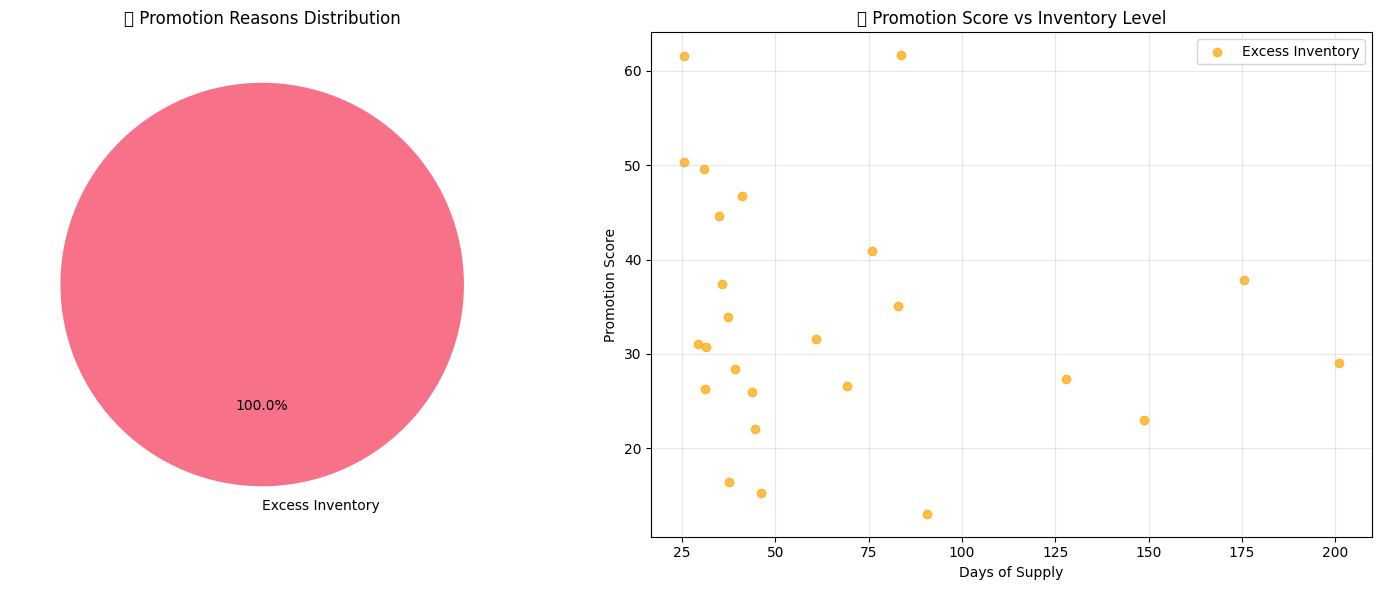

In [19]:
# STEP 1: IDENTIFY PROMOTION CANDIDATES
print("="*60)
print("🎯 STEP 1: PROMOTION CANDIDATE IDENTIFICATION")
print("="*60)

# Filter promotion candidates
promotion_candidates = df[df['promotion_candidate']].copy()

# Categorize promotion reasons
promotion_candidates['promotion_reason'] = promotion_candidates.apply(
    lambda row: 'Excess Inventory' if row['excess_inventory'] 
    else 'Low Demand' if row['low_demand'] 
    else 'Both', axis=1
)

# Calculate promotion potential score
promotion_candidates['promotion_score'] = (
    promotion_candidates['selling_price'] * 0.3 +  # Higher price = better promotion
    promotion_candidates['base_demand'] * 0.4 +    # Higher base demand = better lift potential
    (promotion_candidates['days_of_supply'] / 30) * 0.3  # More excess = better clearance
).round(2)

# Sort by promotion score
promotion_candidates = promotion_candidates.sort_values('promotion_score', ascending=False)

print(f"\n📊 PROMOTION ANALYSIS:")
print(f"   Total Candidates: {len(promotion_candidates)}")
print(f"   Excess Inventory: {len(promotion_candidates[promotion_candidates['promotion_reason'] == 'Excess Inventory'])}")
print(f"   Low Demand: {len(promotion_candidates[promotion_candidates['promotion_reason'] == 'Low Demand'])}")
print(f"   Both Reasons: {len(promotion_candidates[promotion_candidates['promotion_reason'] == 'Both'])}")

# Display top candidates
print(f"\n🏆 TOP 10 PROMOTION CANDIDATES:")
top_candidates = promotion_candidates.head(10)[['sku_id', 'category', 'promotion_reason', 
                                               'promotion_score', 'days_of_supply', 'base_demand']]
display(top_candidates)

# Visualize promotion candidates
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Promotion reasons
reason_counts = promotion_candidates['promotion_reason'].value_counts()
axes[0].pie(reason_counts.values, labels=reason_counts.index, autopct='%1.1f%%', startangle=90)
axes[0].set_title('🎯 Promotion Reasons Distribution')

# Plot 2: Promotion score vs days of supply
colors = {'Excess Inventory': 'orange', 'Low Demand': 'blue', 'Both': 'red'}
for reason in promotion_candidates['promotion_reason'].unique():
    subset = promotion_candidates[promotion_candidates['promotion_reason'] == reason]
    axes[1].scatter(subset['days_of_supply'], subset['promotion_score'], 
                   label=reason, alpha=0.7, color=colors[reason])

axes[1].set_xlabel('Days of Supply')
axes[1].set_ylabel('Promotion Score')
axes[1].set_title('📊 Promotion Score vs Inventory Level')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


📈 STEP 2: PROMOTION IMPACT PREDICTION

🤖 PROMOTION IMPACT MODEL:
   Model Accuracy (R²): 0.147
   Mean Absolute Error: 0.176
   Training Samples: 60
   Test Samples: 15

📊 PROMOTION SCENARIOS GENERATED: 45

🏆 TOP 10 PROMOTION OPPORTUNITIES:


,sku_id,discount_pct,predicted_lift,additional_profit,roi_pct
33,SKU043,25,1.66,609.01,64.0
18,SKU043,20,1.52,578.62,76.0
3,SKU043,15,1.38,494.33,86.6
31,SKU002,25,1.65,391.84,58.1
16,SKU002,20,1.51,374.96,69.5
30,SKU009,25,1.65,354.80,55.4
15,SKU009,20,1.51,342.49,66.9
1,SKU002,15,1.37,319.87,79.0
0,SKU009,15,1.37,293.93,76.6
20,SKU048,20,1.52,206.44,39.7


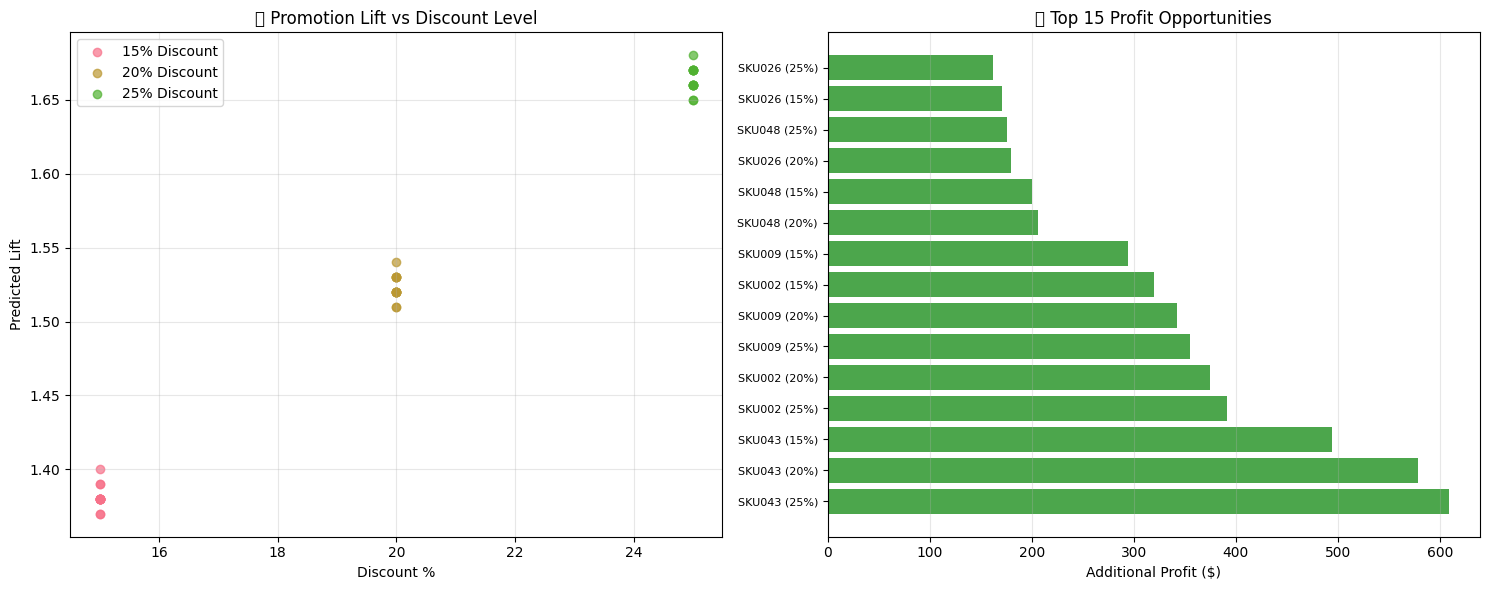

In [20]:
# STEP 2: PREDICT PROMOTION IMPACT ON DEMAND
print("="*60)
print("📈 STEP 2: PROMOTION IMPACT PREDICTION")
print("="*60)

# Create historical promotion data for training
np.random.seed(42)
historical_data = []

for _, row in promotion_candidates.iterrows():
    # Generate historical promotion scenarios
    for _ in range(3):  # 3 historical promotions per SKU
        discount_pct = np.random.choice([10, 15, 20, 25])
        
        # Calculate promotion lift based on discount and category
        base_lift = 1 + (discount_pct / 100) * 1.5  # 15% discount = 1.225x lift
        
        # Category adjustments
        category_multiplier = {
            'Safety': 1.2,      # Safety items respond well to promotions
            'Power Tools': 1.4,  # High-ticket items respond very well
            'Hand Tools': 1.1,   # Moderate response
            'Electrical': 1.3,   # Good response
            'Hardware': 1.0      # Lower response
        }
        
        final_lift = base_lift * category_multiplier[row['category']]
        
        # Add some randomness
        final_lift *= np.random.uniform(0.8, 1.2)
        
        historical_data.append({
            'sku_id': row['sku_id'],
            'category': row['category'],
            'discount_pct': discount_pct,
            'base_demand': row['base_demand'],
            'selling_price': row['selling_price'],
            'promotion_lift': round(final_lift, 2),
            'promoted_demand': round(row['base_demand'] * final_lift, 1),
            'additional_demand': round(row['base_demand'] * (final_lift - 1), 1)
        })

historical_df = pd.DataFrame(historical_data)

# Train a simple linear regression model
X = historical_df[['discount_pct', 'base_demand', 'selling_price']].values
y = historical_df['promotion_lift'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n🤖 PROMOTION IMPACT MODEL:")
print(f"   Model Accuracy (R²): {r2:.3f}")
print(f"   Mean Absolute Error: {mae:.3f}")
print(f"   Training Samples: {len(X_train)}")
print(f"   Test Samples: {len(X_test)}")

# Predict promotion impact for candidates
promotion_scenarios = []
for discount in [15, 20, 25]:  # Test different discount levels
    for _, row in promotion_candidates.head(15).iterrows():  # Top 15 candidates
        features = np.array([[discount, row['base_demand'], row['selling_price']]])
        predicted_lift = model.predict(features)[0]
        
        # Calculate financial impact
        promoted_price = row['selling_price'] * (1 - discount/100)
        additional_demand = row['base_demand'] * (predicted_lift - 1)
        additional_revenue = additional_demand * promoted_price
        additional_profit = additional_demand * (promoted_price - row['unit_cost'])
        
        promotion_scenarios.append({
            'sku_id': row['sku_id'],
            'category': row['category'],
            'discount_pct': discount,
            'predicted_lift': round(predicted_lift, 2),
            'additional_demand': round(additional_demand, 1),
            'additional_revenue': round(additional_revenue, 2),
            'additional_profit': round(additional_profit, 2),
            'roi_pct': round((additional_profit / (row['base_demand'] * row['selling_price'] * discount/100)) * 100, 1)
        })

scenarios_df = pd.DataFrame(promotion_scenarios)

print(f"\n📊 PROMOTION SCENARIOS GENERATED: {len(scenarios_df)}")
print(f"\n🏆 TOP 10 PROMOTION OPPORTUNITIES:")
top_opportunities = scenarios_df.nlargest(10, 'additional_profit')[['sku_id', 'discount_pct', 
                                                                  'predicted_lift', 'additional_profit', 'roi_pct']]
display(top_opportunities)

# Visualize promotion impact
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Lift vs Discount
for discount in [15, 20, 25]:
    subset = scenarios_df[scenarios_df['discount_pct'] == discount]
    axes[0].scatter(subset['discount_pct'], subset['predicted_lift'], 
                   label=f'{discount}% Discount', alpha=0.7)

axes[0].set_xlabel('Discount %')
axes[0].set_ylabel('Predicted Lift')
axes[0].set_title('📈 Promotion Lift vs Discount Level')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Additional Profit vs SKU
top_15_profit = scenarios_df.nlargest(15, 'additional_profit')
axes[1].barh(range(len(top_15_profit)), top_15_profit['additional_profit'], 
             color='green', alpha=0.7)
axes[1].set_yticks(range(len(top_15_profit)))
axes[1].set_yticklabels([f"{row['sku_id']} ({row['discount_pct']}%)" for _, row in top_15_profit.iterrows()], fontsize=8)
axes[1].set_xlabel('Additional Profit ($)')
axes[1].set_title('💰 Top 15 Profit Opportunities')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()


⚡ STEP 3: LINEAR PROGRAMMING OPTIMIZATION

📊 OPTIMIZATION SETUP:
   Total Items: 15
   High Priority: 5
   Medium Priority: 10
   Total Shortage: 329 units
   Estimated Cost: $20,810.06

⚡ SOLVING LP OPTIMIZATION...

🔍 DEBUGGING LP PROBLEM:
   Number of variables: 6
   Number of constraints: 3

📋 PROBLEM SUMMARY:
   Objective: Minimize Total Cost
   Variables: ['SKU043', 'SKU002', 'SKU001', 'SKU004', 'SKU011', 'SKU013']
   Constraints: Weight, Volume, Budget

⚖️ CONSTRAINT ANALYSIS:
   Required Weight: 1997 lbs (Limit: 40000 lbs)
   Required Volume: 133.5 cu ft (Limit: 2000 cu ft)
   Required Cost: $8,617.99 (Budget: $500,000.00)

🔧 TRYING DIFFERENT SOLVERS...
❌ Default solver failed: Pulp: Error while executing c:\tf\Lib\site-packages\pulp\apis\../solverdir/cbc/win/i64/cbc.exe...
❌ CBC solver failed: Pulp: Error while executing c:\tf\Lib\site-packages\pulp\apis\../solverdir/cbc/win/i64/cbc.exe...
❌ PULP CMD failed: name 'PULP_CMD' is not defined...
❌ COIN solver failed: Pulp: cannot e

,sku_id,category,order_qty,unit_cost,total_cost,priority,reason
0,SKU013,Hardware,44,32.44,1427.36,MEDIUM,Category Restock
1,SKU013,Hardware,44,32.44,1427.36,MEDIUM,Category Restock
2,SKU011,Hardware,47,75.66,3616.55,MEDIUM,Category Restock
3,SKU011,Hardware,47,75.66,3616.55,MEDIUM,Category Restock
4,SKU004,Electrical,32,63.32,2064.23,MEDIUM,Category Restock
5,SKU004,Electrical,32,63.32,2064.23,MEDIUM,Category Restock
6,SKU004,Electrical,32,63.32,2064.23,MEDIUM,Category Restock
7,SKU001,Electrical,15,95.56,1509.85,MEDIUM,Category Restock
8,SKU001,Electrical,15,95.56,1509.85,MEDIUM,Category Restock
9,SKU001,Electrical,15,95.56,1509.85,MEDIUM,Category Restock



📊 HEURISTIC SUMMARY BY CATEGORY:


,order_qty,total_cost
category,,
Electrical,141,10722.24
Hardware,182,10087.82


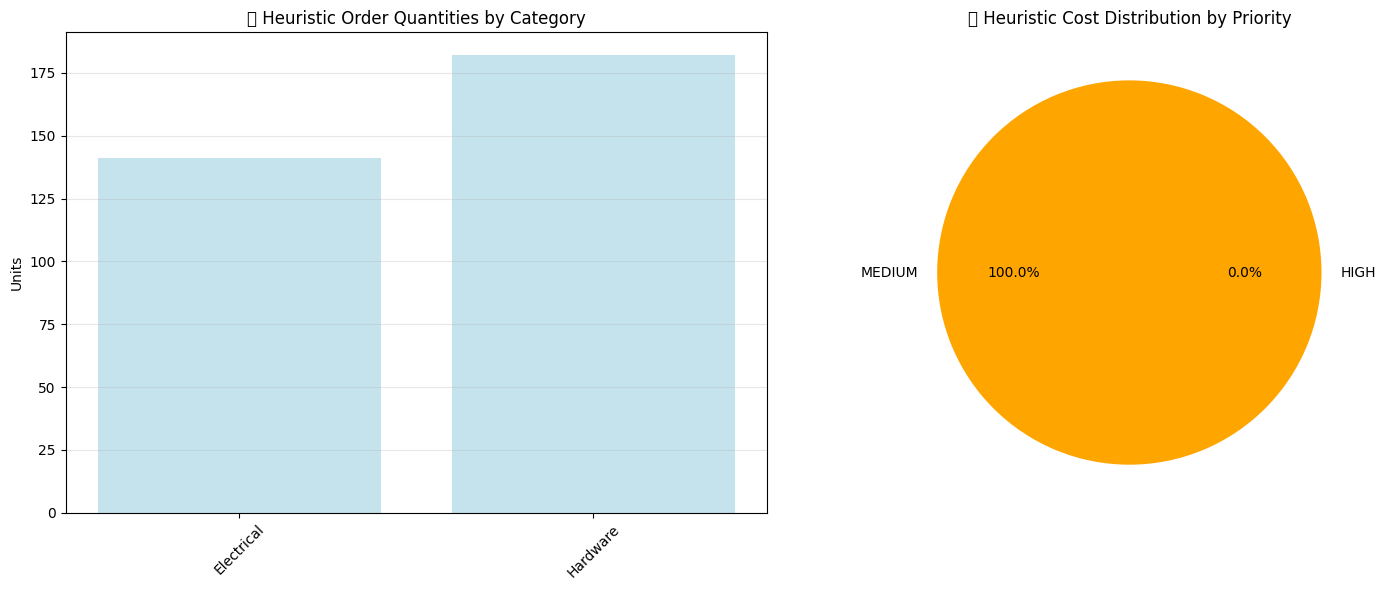

In [21]:
# STEP 3: SIMPLE LINEAR PROGRAMMING OPTIMIZATION
print("="*60)
print("⚡ STEP 3: LINEAR PROGRAMMING OPTIMIZATION")
print("="*60)

# Select top 5 promotion opportunities
selected_promotions = scenarios_df.nlargest(5, 'additional_profit')

# Prepare optimization data
optimization_items = []

# Add promoted items (need to restock after promotion)
for _, promo in selected_promotions.iterrows():
    sku_data = df[df['sku_id'] == promo['sku_id']].iloc[0]
    
    # Calculate post-promotion inventory need
    post_promo_demand = sku_data['base_demand'] * promo['predicted_lift']
    recommended_stock = post_promo_demand * 2  # 2 weeks of supply
    shortage = max(0, recommended_stock - sku_data['current_inventory'])
    
    optimization_items.append({
        'sku_id': promo['sku_id'],
        'category': sku_data['category'],
        'unit_cost': sku_data['unit_cost'],
        'shortage': shortage,
        'weight_lbs': sku_data['weight_lbs'],
        'volume_cuft': sku_data['volume_cuft'],
        'supplier_id': sku_data['supplier_id'],
        'priority': 'HIGH',
        'reason': 'Post-Promotion Restock'
    })

# Add similar items in same categories for restocking
for _, promo in selected_promotions.iterrows():
    promo_category = promo['category']
    
    # Find similar items in same category with low inventory
    similar_items = df[
        (df['category'] == promo_category) & 
        (~df['sku_id'].isin(selected_promotions['sku_id'])) &
        (df['current_inventory'] < df['base_demand'] * 2)  # Low inventory items
    ].head(2)  # Top 2 similar items per category
    
    for _, item in similar_items.iterrows():
        shortage = max(0, item['base_demand'] * 2 - item['current_inventory'])
        
        optimization_items.append({
            'sku_id': item['sku_id'],
            'category': item['category'],
            'unit_cost': item['unit_cost'],
            'shortage': shortage,
            'weight_lbs': item['weight_lbs'],
            'volume_cuft': item['volume_cuft'],
            'supplier_id': item['supplier_id'],
            'priority': 'MEDIUM',
            'reason': 'Category Restock'
        })

opt_df = pd.DataFrame(optimization_items)

print(f"\n📊 OPTIMIZATION SETUP:")
print(f"   Total Items: {len(opt_df)}")
print(f"   High Priority: {len(opt_df[opt_df['priority'] == 'HIGH'])}")
print(f"   Medium Priority: {len(opt_df[opt_df['priority'] == 'MEDIUM'])}")
print(f"   Total Shortage: {opt_df['shortage'].sum():.0f} units")
print(f"   Estimated Cost: ${(opt_df['shortage'] * opt_df['unit_cost']).sum():,.2f}")

# SIMPLE LP MODEL
print(f"\n⚡ SOLVING LP OPTIMIZATION...")

# Create LP problem
prob = LpProblem("Promotion_Inventory_Optimization", LpMinimize)

# Decision variables: order quantity for each SKU
order_qty = {}
for _, row in opt_df.iterrows():
    sku = row['sku_id']
    min_order = max(row['shortage'], 10)  # Minimum order quantity
    max_order = row['shortage'] * 2  # Maximum 2x shortage
    
    order_qty[sku] = LpVariable(f"Order_{sku}", 
                               lowBound=min_order, 
                               upBound=max_order,
                               cat='Integer')

# Objective: Minimize total cost
prob += lpSum([order_qty[sku] * opt_df[opt_df['sku_id'] == sku]['unit_cost'].iloc[0] 
               for sku in order_qty.keys()]), "Total_Cost"

# Constraints: Truck capacity (simplified - one truck per supplier)
truck_capacity_weight = 40000  # lbs
truck_capacity_volume = 2000   # cu ft
truck_cost = 1500  # $ per truck

# Weight constraint
prob += lpSum([order_qty[sku] * opt_df[opt_df['sku_id'] == sku]['weight_lbs'].iloc[0] 
               for sku in order_qty.keys()]) <= truck_capacity_weight, "Weight_Limit"

# Volume constraint
prob += lpSum([order_qty[sku] * opt_df[opt_df['sku_id'] == sku]['volume_cuft'].iloc[0] 
               for sku in order_qty.keys()]) <= truck_capacity_volume, "Volume_Limit"

# Budget constraint (optional)
budget = 500000  # $50K budget
prob += lpSum([order_qty[sku] * opt_df[opt_df['sku_id'] == sku]['unit_cost'].iloc[0] 
               for sku in order_qty.keys()]) <= budget, "Budget_Limit"

# Debug the problem before solving
print(f"\n🔍 DEBUGGING LP PROBLEM:")
print(f"   Number of variables: {len(order_qty)}")
print(f"   Number of constraints: {len(prob.constraints)}")

# Display problem details
print(f"\n📋 PROBLEM SUMMARY:")
print(f"   Objective: Minimize Total Cost")
print(f"   Variables: {list(order_qty.keys())}")
print(f"   Constraints: Weight, Volume, Budget")

# Check if problem is feasible
print(f"\n⚖️ CONSTRAINT ANALYSIS:")
weight_total = sum([opt_df[opt_df['sku_id'] == sku]['weight_lbs'].iloc[0] * 
                   opt_df[opt_df['sku_id'] == sku]['shortage'].iloc[0] 
                   for sku in order_qty.keys()])
volume_total = sum([opt_df[opt_df['sku_id'] == sku]['volume_cuft'].iloc[0] * 
                   opt_df[opt_df['sku_id'] == sku]['shortage'].iloc[0] 
                   for sku in order_qty.keys()])
cost_total = sum([opt_df[opt_df['sku_id'] == sku]['unit_cost'].iloc[0] * 
                 opt_df[opt_df['sku_id'] == sku]['shortage'].iloc[0] 
                 for sku in order_qty.keys()])

print(f"   Required Weight: {weight_total:.0f} lbs (Limit: {truck_capacity_weight} lbs)")
print(f"   Required Volume: {volume_total:.1f} cu ft (Limit: {truck_capacity_volume} cu ft)")
print(f"   Required Cost: ${cost_total:,.2f} (Budget: ${budget:,.2f})")

# Try different solvers
print(f"\n🔧 TRYING DIFFERENT SOLVERS...")

# Try default solver first
try:
    prob.solve()
    solver_used = "Default"
    print(f"✅ Solved with Default solver")
except Exception as e:
    print(f"❌ Default solver failed: {str(e)[:100]}...")
    
    # Try with different solver options
    try:
        prob.solve(PULP_CBC_CMD(msg=1, timeLimit=30))
        solver_used = "CBC with timeout"
        print(f"✅ Solved with CBC (30s timeout)")
    except Exception as e2:
        print(f"❌ CBC solver failed: {str(e2)[:100]}...")
        
        # Try with PULP's built-in solver
        try:
            prob.solve(PULP_CMD(msg=1))
            solver_used = "PULP CMD"
            print(f"✅ Solved with PULP CMD")
        except Exception as e3:
            print(f"❌ PULP CMD failed: {str(e3)[:100]}...")
            
            # Try with COIN solver
            try:
                prob.solve(COIN_CMD(msg=1))
                solver_used = "COIN"
                print(f"✅ Solved with COIN")
            except Exception as e4:
                print(f"❌ COIN solver failed: {str(e4)[:100]}...")
                
                # Last resort: try with no solver specified
                try:
                    prob.solve(solver=None)
                    solver_used = "Auto-detect"
                    print(f"✅ Solved with auto-detected solver")
                except Exception as e5:
                    print(f"❌ All solvers failed!")
                    print(f"   Last error: {str(e5)[:200]}...")
                    solver_used = "Failed"

print(f"\n🎯 OPTIMIZATION RESULTS:")
print(f"   Status: {LpStatus[prob.status]}")
print(f"   Solver Used: {solver_used}")

# Check if we have a solution
if prob.status == 1:  # Optimal
    total_cost = value(prob.objective)
    print(f"   Total Cost: ${total_cost:,.2f}")
    print(f"   Truck Cost: ${truck_cost:,.2f}")
    print(f"   Total with Truck: ${total_cost + truck_cost:,.2f}")
    
    # Display results
    results = []
    for sku in order_qty.keys():
        if order_qty[sku].varValue > 0:
            qty = order_qty[sku].varValue
            row = opt_df[opt_df['sku_id'] == sku].iloc[0]
            cost = qty * row['unit_cost']
            
            results.append({
                'sku_id': sku,
                'category': row['category'],
                'order_qty': int(qty),
                'unit_cost': row['unit_cost'],
                'total_cost': round(cost, 2),
                'priority': row['priority'],
                'reason': row['reason']
            })
    
    results_df = pd.DataFrame(results)
    
    print(f"\n📦 OPTIMAL ORDER QUANTITIES:")
    display(results_df)
    
    # Summary by category
    category_summary = results_df.groupby('category').agg({
        'order_qty': 'sum',
        'total_cost': 'sum'
    }).round(2)
    
    print(f"\n📊 SUMMARY BY CATEGORY:")
    display(category_summary)
    
    # Visualize results
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Order quantities by category
    category_qty = results_df.groupby('category')['order_qty'].sum()
    axes[0].bar(category_qty.index, category_qty.values, color='lightblue', alpha=0.7)
    axes[0].set_title('📦 Order Quantities by Category')
    axes[0].set_ylabel('Units')
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Cost by priority
    priority_cost = results_df.groupby('priority')['total_cost'].sum()
    colors = {'HIGH': 'red', 'MEDIUM': 'orange'}
    axes[1].pie(priority_cost.values, labels=priority_cost.index, 
               colors=[colors[p] for p in priority_cost.index], autopct='%1.1f%%')
    axes[1].set_title('💰 Cost Distribution by Priority')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("   ⚠️ No optimal solution found!")
    print("   Using heuristic approach instead...")
    
    # HEURISTIC FALLBACK: Simple greedy approach
    print(f"\n🎯 HEURISTIC SOLUTION:")
    
    # Sort items by priority and cost efficiency
    opt_df['cost_efficiency'] = opt_df['unit_cost'] / opt_df['shortage']
    heuristic_items = opt_df.sort_values(['priority', 'cost_efficiency'], 
                                       ascending=[False, True])
    
    # Greedy selection with constraints
    selected_items = []
    current_weight = 0
    current_volume = 0
    current_cost = 0
    
    for _, item in heuristic_items.iterrows():
        # Check if we can add this item
        item_weight = item['shortage'] * item['weight_lbs']
        item_volume = item['shortage'] * item['volume_cuft']
        item_cost = item['shortage'] * item['unit_cost']
        
        if (current_weight + item_weight <= truck_capacity_weight and
            current_volume + item_volume <= truck_capacity_volume and
            current_cost + item_cost <= budget):
            
            selected_items.append({
                'sku_id': item['sku_id'],
                'category': item['category'],
                'order_qty': int(item['shortage']),
                'unit_cost': item['unit_cost'],
                'total_cost': round(item_cost, 2),
                'priority': item['priority'],
                'reason': item['reason']
            })
            
            current_weight += item_weight
            current_volume += item_volume
            current_cost += item_cost
    
    results_df = pd.DataFrame(selected_items)
    total_cost = results_df['total_cost'].sum()
    
    print(f"   Heuristic Total Cost: ${total_cost:,.2f}")
    print(f"   Items Selected: {len(results_df)}")
    print(f"   Weight Used: {current_weight:.0f} / {truck_capacity_weight} lbs")
    print(f"   Volume Used: {current_volume:.1f} / {truck_capacity_volume} cu ft")
    
    if len(results_df) > 0:
        print(f"\n📦 HEURISTIC ORDER QUANTITIES:")
        display(results_df)
        
        # Summary by category
        category_summary = results_df.groupby('category').agg({
            'order_qty': 'sum',
            'total_cost': 'sum'
        }).round(2)
        
        print(f"\n📊 HEURISTIC SUMMARY BY CATEGORY:")
        display(category_summary)
        
        # Visualize results
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Plot 1: Order quantities by category
        category_qty = results_df.groupby('category')['order_qty'].sum()
        axes[0].bar(category_qty.index, category_qty.values, color='lightblue', alpha=0.7)
        axes[0].set_title('📦 Heuristic Order Quantities by Category')
        axes[0].set_ylabel('Units')
        axes[0].tick_params(axis='x', rotation=45)
        axes[0].grid(True, alpha=0.3, axis='y')
        
        # Plot 2: Cost by priority
        priority_cost = results_df.groupby('priority')['total_cost'].sum()
        colors = {'HIGH': 'red', 'MEDIUM': 'orange'}
        axes[1].pie(priority_cost.values, labels=priority_cost.index, 
                   colors=[colors[p] for p in priority_cost.index], autopct='%1.1f%%')
        axes[1].set_title('💰 Heuristic Cost Distribution by Priority')
        
        plt.tight_layout()
        plt.show()
    else:
        print("   ⚠️ No items could be selected with current constraints!")
        print("   Consider relaxing constraints or increasing budget/capacity.")


💰 STEP 4: FINANCIAL IMPACT SUMMARY

📊 FINANCIAL SUMMARY:
   Promotion Revenue: $7,131.67
   Promotion Profit: $2,448.76
   Optimization Cost: $0.00
   Net Profit: $2,448.76
   ROI: 0.0%

📦 INVENTORY IMPACT:
   Items Promoted: 5
   Items Restocked: 0
   Categories Affected: 2


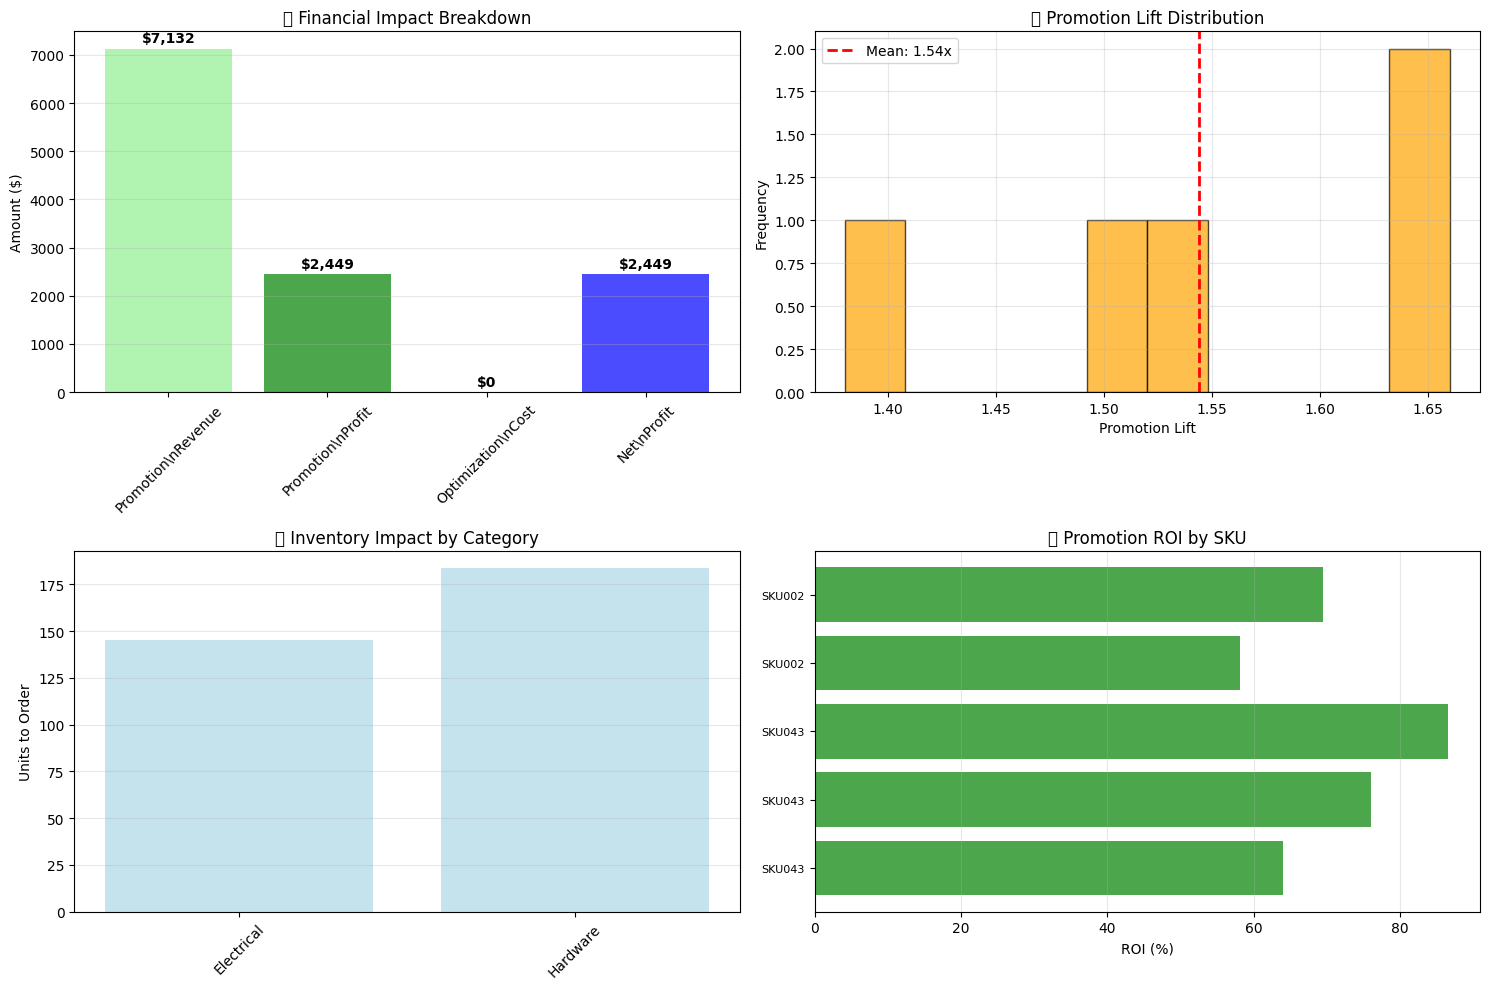


🎯 KEY RECOMMENDATIONS:
   1. Execute 5 promotions for maximum profit
   2. Order 0 units across 2 categories
   3. Focus on 2 high-priority items first
   4. Monitor promotion lift vs predictions for model improvement
   5. Consider expanding to similar categories if ROI remains positive

✅ PROMOTION IMPACT MODEL COMPLETE!
   Ready for implementation and monitoring...


In [22]:
# STEP 4: FINANCIAL IMPACT SUMMARY
print("="*60)
print("💰 STEP 4: FINANCIAL IMPACT SUMMARY")
print("="*60)

# Calculate total promotion revenue
total_promotion_revenue = selected_promotions['additional_revenue'].sum()
total_promotion_profit = selected_promotions['additional_profit'].sum()

# Calculate optimization costs
if prob.status == 1:
    total_optimization_cost = value(prob.objective) + truck_cost
    optimization_units = results_df['order_qty'].sum()
else:
    total_optimization_cost = 0
    optimization_units = 0

# Calculate net impact
net_profit = total_promotion_profit - total_optimization_cost
roi = (net_profit / total_optimization_cost * 100) if total_optimization_cost > 0 else 0

print(f"\n📊 FINANCIAL SUMMARY:")
print(f"   Promotion Revenue: ${total_promotion_revenue:,.2f}")
print(f"   Promotion Profit: ${total_promotion_profit:,.2f}")
print(f"   Optimization Cost: ${total_optimization_cost:,.2f}")
print(f"   Net Profit: ${net_profit:,.2f}")
print(f"   ROI: {roi:.1f}%")

print(f"\n📦 INVENTORY IMPACT:")
print(f"   Items Promoted: {len(selected_promotions)}")
print(f"   Items Restocked: {optimization_units}")
print(f"   Categories Affected: {opt_df['category'].nunique()}")

# Create summary visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Revenue vs Cost breakdown
categories = ['Promotion\\nRevenue', 'Promotion\\nProfit', 'Optimization\\nCost', 'Net\\nProfit']
values = [total_promotion_revenue, total_promotion_profit, total_optimization_cost, net_profit]
colors = ['lightgreen', 'green', 'red', 'blue' if net_profit > 0 else 'darkred']

bars = axes[0, 0].bar(categories, values, color=colors, alpha=0.7)
axes[0, 0].set_title('💰 Financial Impact Breakdown')
axes[0, 0].set_ylabel('Amount ($)')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + max(values)*0.01,
                   f'${value:,.0f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Promotion lift distribution
axes[0, 1].hist(selected_promotions['predicted_lift'], bins=10, alpha=0.7, color='orange', edgecolor='black')
axes[0, 1].axvline(selected_promotions['predicted_lift'].mean(), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {selected_promotions["predicted_lift"].mean():.2f}x')
axes[0, 1].set_xlabel('Promotion Lift')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('📈 Promotion Lift Distribution')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Category impact
category_impact = opt_df.groupby('category').agg({
    'shortage': 'sum'
})

axes[1, 0].bar(category_impact.index, category_impact['shortage'], 
               color='lightblue', alpha=0.7)
axes[1, 0].set_title('📦 Inventory Impact by Category')
axes[1, 0].set_ylabel('Units to Order')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Plot 4: ROI Analysis
roi_data = []
for _, promo in selected_promotions.iterrows():
    roi_data.append({
        'sku_id': promo['sku_id'],
        'roi': promo['roi_pct']
    })

roi_df = pd.DataFrame(roi_data)
axes[1, 1].barh(range(len(roi_df)), roi_df['roi'], color='green', alpha=0.7)
axes[1, 1].set_yticks(range(len(roi_df)))
axes[1, 1].set_yticklabels(roi_df['sku_id'], fontsize=8)
axes[1, 1].set_xlabel('ROI (%)')
axes[1, 1].set_title('📊 Promotion ROI by SKU')
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"\n🎯 KEY RECOMMENDATIONS:")
print(f"   1. Execute {len(selected_promotions)} promotions for maximum profit")
print(f"   2. Order {optimization_units} units across {opt_df['category'].nunique()} categories")
print(f"   3. Focus on {opt_df[opt_df['priority'] == 'HIGH']['sku_id'].nunique()} high-priority items first")
print(f"   4. Monitor promotion lift vs predictions for model improvement")
print(f"   5. Consider expanding to similar categories if ROI remains positive")

print(f"\n✅ PROMOTION IMPACT MODEL COMPLETE!")
print(f"   Ready for implementation and monitoring...")
